In [ ]:
import numpy as np
import mujoco
import os
from ament_index_python.packages import get_package_share_directory

from mjx_planner_proj_check import cem_planner
from quat_math import quaternion_distance, quaternion_multiply, rotation_quaternion
# from sampling_based_planner.Simple_MLP.mlp_singledof import MLP, MLPProjectionFilter


In [2]:
# model_path = os.path.join(get_package_share_directory('real_demo'), 'panda_mjx', 'franka_emika_panda', 'panda_scene.xml')

print(os.getcwd())


/home/alinjar/colcon_ws/src/manipulator_mujoco/real_demo/sampling_based_planner


In [3]:
# model_path = "../panda_mjx/franka_emika_panda/panda_scene.xml"
model_path = "../ur5e_hande_mjx/scene.xml"
num_dof = 12
num_batch = 20
num_steps = 15
maxiter_cem = 1
num_elite = 0.5
timestep = 0.1
maxiter_projection = 5
max_joint_pos = 180.0*np.pi/180.0
max_joint_vel=1.0
max_joint_acc = 2.0
max_joint_jerk=4.0
w_pos = 1.0
w_rot = 1.0
w_col = 1.0


model = mujoco.MjModel.from_xml_path(model_path)
data = mujoco.MjData(model)
cem = cem_planner(
            model=model,
            num_dof=num_dof, 
            num_batch=num_batch, 
            num_steps=num_steps, 
            maxiter_cem=maxiter_cem,
            num_elite=num_elite,
            timestep=timestep,
            maxiter_projection=maxiter_projection,
            max_joint_pos=max_joint_pos,
            max_joint_vel=max_joint_vel,
            max_joint_acc=max_joint_acc,
            max_joint_jerk=max_joint_jerk,

        )


Found geom: id=7, name='robot_1'
Found geom: id=12, name='robot_2'
Found geom: id=13, name='robot_3'
Found geom: id=18, name='robot_4'
Found geom: id=19, name='robot_5'
Found geom: id=23, name='robot_6'
Found geom: id=27, name='robot_7'
Found geom: id=28, name='robot_8'
Found geom: id=32, name='robot_0'
Found geom: id=34, name='robot_01'
Found geom: id=36, name='robot_02'
Found geom: id=43, name='robot_11'
Found geom: id=48, name='robot_12'
Found geom: id=49, name='robot_13'
Found geom: id=54, name='robot_14'
Found geom: id=55, name='robot_15'
Found geom: id=59, name='robot_16'
Found geom: id=63, name='robot_17'
Found geom: id=64, name='robot_18'
Found geom: id=67, name='robot_10'
Found geom: id=70, name='robot_101'
Found geom: id=74, name='robot_103'
Found geom: id=78, name='robot_102'
Found geom: id=82, name='robot_104'
(144,)
(15, 144)

 Default backend: gpu
 Timestep: 0.1 
 CEM Iter: 1 
 Projection Iter: 5 
 Number of batches: 20 
 Number of steps per trajectory: 15 
 Time per traj

In [4]:
# import jax
# def compute_xi_samples(self, key, xi_mean, xi_cov ):
#     key, subkey = jax.random.split(key)
#     xi_samples = jax.random.multivariate_normal(key, xi_mean, xi_cov+0.003*jnp.identity(self.nvar), (self.num_batch, ))
#     return xi_samples, key

import jax
import jax.numpy as jnp

In [5]:
# print(cem.timestep)

In [6]:
xi_mean_single = jnp.zeros(cem.nvar_single)
xi_cov_single = 1.0*jnp.identity(cem.nvar_single)
xi_mean = jnp.tile(xi_mean_single, cem.num_dof)
xi_cov = jnp.kron(jnp.eye(cem.num_dof), xi_cov_single)
key = jax.random.PRNGKey(42)
xi_samples, _ = cem.compute_xi_samples(key, xi_mean, xi_cov)

# init_pos = jnp.array([0.0, -0.3, 0.0, -2.0, 0.0, 1.7,
#                       0.0, -0.3, 0.0, -2.0, 0.0, 1.7])

init_pos = jnp.array([1.5, -1.8, 1.75, -1.25, -1.6, 0, -1.5, -1.8, 1.75, -1.25, -1.6, 0])

init_vel = jnp.array([0.1, 0.2, 0.05, -0.05, 0.01, 0.05,
                      0.0, 0.1, 0.04, 0.07, 0.03, 0.1])

init_acc = jnp.zeros_like(init_pos)


In [7]:
target_pos_0 = data.xpos[model.body(name="target_0").id]
target_rot_0 = data.xquat[model.body(name="target_0").id].copy()
target_0 = np.concatenate([target_pos_0, target_rot_0])

target_pos_2 = data.xpos[model.body(name="ball").id]
target_rot_2 = data.xquat[model.body(name="ball").id].copy()
target_2 = np.concatenate([target_pos_2, target_rot_2])

ball_pick_init = target_2

# Get obstacle reference
obstacle_pos = data.mocap_pos[model.body_mocapid[model.body(name='obstacle').id]]
obstacle_rot = data.mocap_quat[model.body_mocapid[model.body(name='obstacle').id]]

# def update_targets(self, target_idx=0, target_pos=None, target_rot=None):
#     """Update target positions and rotations for both arms"""
#     if target_idx==0:
#         self.target_pos_0 = target_pos
#         self.target_rot_0 = target_rot
#         self.target_0 = np.concatenate([self.target_pos_0, self.target_rot_0])
#     elif target_idx==1:
#         self.target_pos_1 = target_pos
#         self.target_rot_1 = target_rot
#         self.target_1 = np.concatenate([self.target_pos_1, self.target_rot_1])
    
# def update_obstacle(self, obstacle_pos, obstacle_rot):
#     """Update obstacle position and rotation"""
#     self.obstacle_pos = obstacle_pos
#     self.obstacle_rot = obstacle_rot


In [8]:


lamda_init = jnp.zeros((num_batch, cem.nvar))
s_init = jnp.zeros((num_batch, cem.num_total_constraints))

cost_weights = {
    'collision': 500,
    'theta': 0.3,
    'z-axis': 10.0,
    'velocity': 0.1,
    'distance': 7.0,

    'allign': 2.0,
    'orientation': 7.0,
    'eef_to_obj': 10.0,
    'obj_to_targ': 1.0,

    'pick': 0,
    'move': 0
}



In [9]:
# opt_class = cem_planner(num_dof=num_dof, num_batch=num_batch, num_steps=num_steps, maxiter_cem=maxiter_cem,
#                         w_pos=w_pos, w_rot=w_rot, w_col=w_col, num_elite=num_elite, timestep=timestep,
#                         maxiter_projection=maxiter_projection,
#                         max_joint_pos = max_joint_pos, max_joint_vel=max_joint_vel, max_joint_acc=max_joint_acc, 
#                         max_joint_jerk=max_joint_jerk)

opt_class = cem_planner(model=model, num_dof=num_dof, num_batch=num_batch, num_steps=num_steps, timestep=timestep, maxiter_cem=maxiter_cem, num_elite=num_elite, 
maxiter_projection=maxiter_projection, max_joint_pos = max_joint_pos ,max_joint_vel = max_joint_vel, 
max_joint_acc = max_joint_acc, max_joint_jerk = max_joint_jerk)


Found geom: id=7, name='robot_1'
Found geom: id=12, name='robot_2'
Found geom: id=13, name='robot_3'
Found geom: id=18, name='robot_4'
Found geom: id=19, name='robot_5'
Found geom: id=23, name='robot_6'
Found geom: id=27, name='robot_7'
Found geom: id=28, name='robot_8'
Found geom: id=32, name='robot_0'
Found geom: id=34, name='robot_01'
Found geom: id=36, name='robot_02'
Found geom: id=43, name='robot_11'
Found geom: id=48, name='robot_12'
Found geom: id=49, name='robot_13'
Found geom: id=54, name='robot_14'
Found geom: id=55, name='robot_15'
Found geom: id=59, name='robot_16'
Found geom: id=63, name='robot_17'
Found geom: id=64, name='robot_18'
Found geom: id=67, name='robot_10'
Found geom: id=70, name='robot_101'
Found geom: id=74, name='robot_103'
Found geom: id=78, name='robot_102'
Found geom: id=82, name='robot_104'
(144,)
(15, 144)

 Default backend: gpu
 Timestep: 0.1 
 CEM Iter: 1 
 Projection Iter: 5 
 Number of batches: 20 
 Number of steps per trajectory: 15 
 Time per traj

In [10]:
num_vel = num_steps
num_acc = num_steps - 1
num_jerk = num_steps - 2
num_pos = num_steps

num_vel_constraints = 2 * num_vel * num_dof
num_acc_constraints = 2 * num_acc * num_dof
num_jerk_constraints = 2 * num_jerk * num_dof
num_pos_constraints = 2 * num_pos * num_dof
num_total_constraints = (num_vel_constraints + num_acc_constraints + num_jerk_constraints + num_pos_constraints)
num_total_constraints_per_dof = 2*(num_vel + num_acc + num_jerk + num_pos)

In [11]:
thetadot_init = jnp.tile(init_vel, (num_batch, 1))

state_term = thetadot_init	

In [12]:
xi_mean_prev = xi_mean 
xi_cov_prev = xi_cov

xi_samples_reshaped = xi_samples.reshape(num_batch, num_dof, num_steps)
xi_samples_batched_over_dof = jnp.transpose(xi_samples_reshaped, (1, 0, 2)) # shape: (DoF, B, num)

state_term_reshaped = state_term.reshape(num_batch, num_dof, 1)
state_term_batched_over_dof = jnp.transpose(state_term_reshaped, (1, 0, 2)) #Shape: (DoF, B, 1)

lamda_init_reshaped = lamda_init.reshape(num_batch, num_dof, num_steps)
lamda_init_batched_over_dof = jnp.transpose(lamda_init_reshaped, (1, 0, 2)) # shape: (DoF, B, num)

s_init_reshaped = s_init.reshape(num_batch, num_dof, num_total_constraints_per_dof)
s_init_batched_over_dof = jnp.transpose(s_init_reshaped, (1, 0, 2)) # shape: (DoF, B, num_total_constraints_per_dof)



# Pass all arguments as positional arguments; not keyword arguments
xi_filtered, primal_residuals, fixed_point_residuals = opt_class.compute_projection_batched_over_dof(
                                                            xi_samples_batched_over_dof, 
                                                            state_term_batched_over_dof, 
                                                            lamda_init_batched_over_dof, 
                                                            s_init_batched_over_dof, 
                                                            init_pos)

xi_filtered = xi_filtered.transpose(1, 0, 2).reshape(num_batch, -1) # shape: (B, num*num_dof)

primal_residuals = jnp.linalg.norm(primal_residuals, axis = 0)
fixed_point_residuals = jnp.linalg.norm(fixed_point_residuals, axis = 0)

In [13]:
print(primal_residuals.shape)
print(fixed_point_residuals.shape)
print(xi_samples.shape)
print(xi_filtered.shape)

(5, 20)
(5, 20)
(20, 180)
(20, 180)


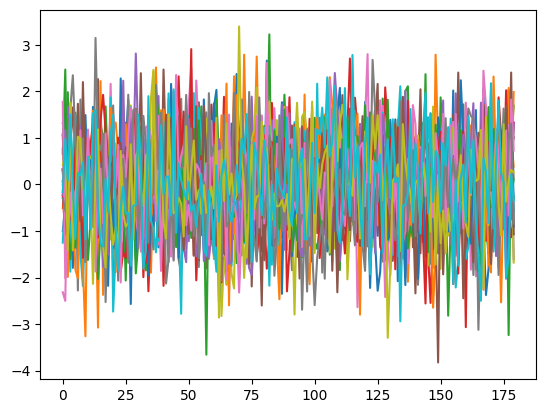

In [14]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(xi_samples.T)
plt.show()

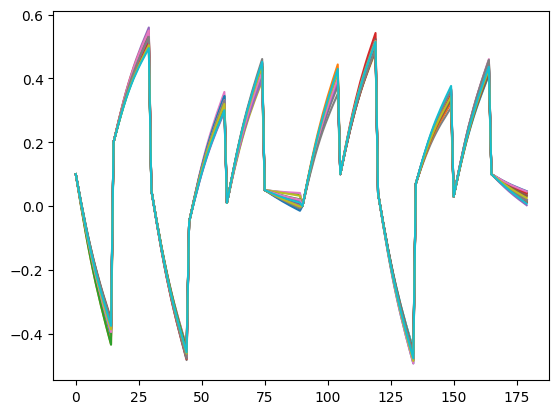

In [15]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(xi_filtered.T)
plt.show()

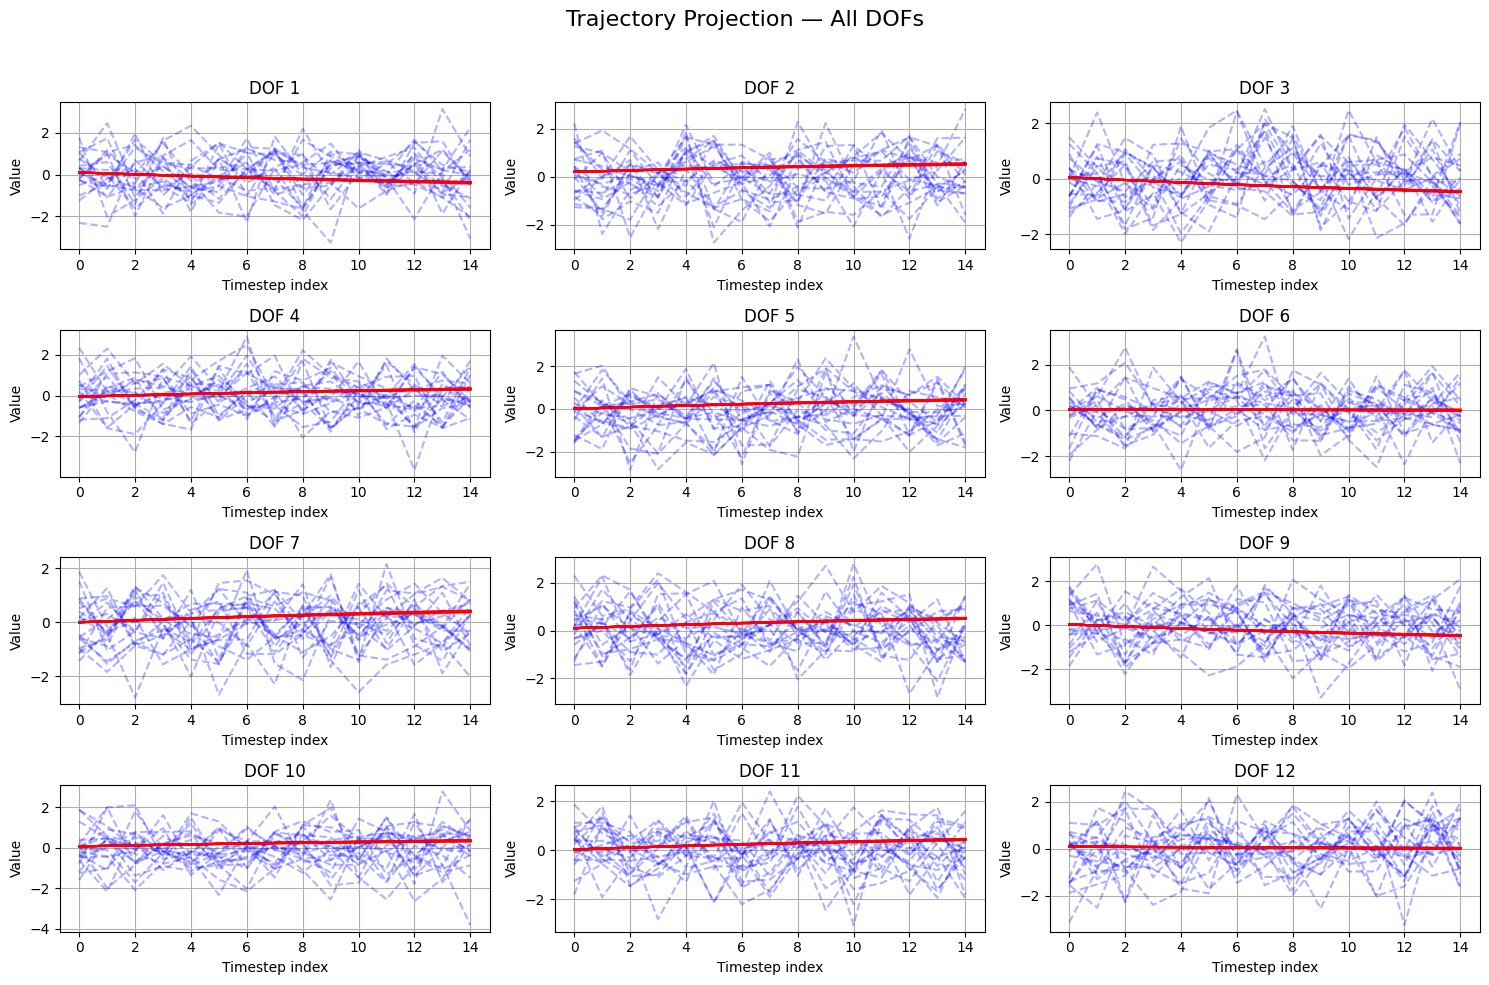

In [16]:
import matplotlib.pyplot as plt
import torch

# Shapes
batch_size, total_dim = xi_samples.shape
num = total_dim // num_dof  # set your actual DOF count

# Reshape to (batch_size, num_dof, num)
xi_s = xi_samples.reshape(batch_size, num_dof, num)
xi_p = xi_filtered.reshape(batch_size, num_dof, num)

# Create a 4x3 grid of subplots
fig, axes = plt.subplots(4, 3, figsize=(15, 10))
axes = axes.flatten()

for d in range(num_dof):
    ax = axes[d]
    for i in range(batch_size):
        ax.plot(xi_s[i, d], color='blue', linestyle='--', alpha=0.3)
        ax.plot(xi_p[i, d], color='red', alpha=0.5)
    ax.set_title(f"DOF {d+1}")
    ax.set_xlabel("Timestep index")
    ax.set_ylabel("Value")
    ax.grid(True)

# Hide any unused subplots if num_dof < 12
for d in range(num_dof, 12):
    fig.delaxes(axes[d])

fig.suptitle("Trajectory Projection — All DOFs", fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


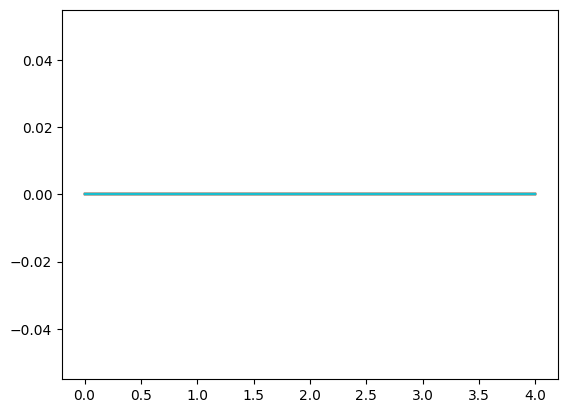

In [17]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(primal_residuals)
plt.show()

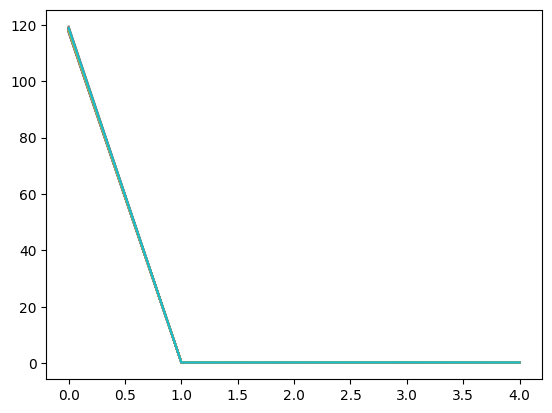

In [18]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fixed_point_residuals)
plt.show()


In [19]:
print(primal_residuals)
print(fixed_point_residuals)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[117.43083    119.0327     117.9884     117.72414    117.953865
  117.35812    118.358406   118.644      118.15429    118.92401
  118.50212    118.884315   117.76937    118.29735    117.5365
  118.60685    118.18716    119.412544   117.928276   118.7954    ]
 [  0.22705382   0.23195113   0.23104958   0.2554509    0.23576707
    0.22994198   0.23914881   0.23593056   0.2231568    0.24392204
    0.23957779   0.24234354   0.25833243   0.23748966   0.22004335
    0.2488642    0.25082818   0.24105942   0.2370717    0.2085329 ]
 [  0.21232805   0.23677087   0.22597839   0.23742838   0.26137277
    0.23658296   0.22763184   0.25526708   0.26731792   0.22961421
    0.2603335    0.25